In [110]:
from src.util import read_gpu_results
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
daic_results = read_gpu_results(from_parquet=False)
daic_results.head()

,dataset,speedup,operator,num_cores,selectivity,cardinality_T,cardinality_S,join,GPU,dataset_type,...,nnz_S,r_T,c_T,sparsity_T,sparsity_S,morpheusfi_p,morpheusfi_q,morpheusfi_eis,morpheusfi_ns,morpheusfi_nis
0,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.247709,Linear Regression,-1,1.05385,100000,105385,preset,2080,synthetic,...,"[100000, 53850]",100000,11,0.0,"[0.0, 0.0]",2,0,[0.0],100000,[5385]
1,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.258619,Linear Regression,-1,1.05385,100000,105385,preset,1080,synthetic,...,"[100000, 53850]",100000,11,0.0,"[0.0, 0.0]",2,0,[0.0],100000,[5385]
2,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.323960,Linear Regression,-1,1.05385,100000,105385,preset,a40,synthetic,...,"[100000, 53850]",100000,11,0.0,"[0.0, 0.0]",2,0,[0.0],100000,[5385]
3,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.417618,Linear Regression,-1,1.05385,100000,105385,preset,p100,synthetic,...,"[100000, 53850]",100000,11,0.0,"[0.0, 0.0]",2,0,[0.0],100000,[5385]
4,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.230622,Linear Regression,-1,1.05385,100000,105385,preset,v100,synthetic,...,"[100000, 53850]",100000,11,0.0,"[0.0, 0.0]",2,0,[0.0],100000,[5385]


In [99]:
daic_results.GPU.unique()

array(['2080', '1080', 'a40', 'p100', 'v100'], dtype=object)

In [116]:
# Add GPU params
gpu_characteristics = {
    "2080": {
        "memory_bandwidth": 448,
        "cores": 2944,
        "clock_speed": 1515,
    },
    "1080": {
        "memory_bandwidth": 320.3,
        "cores": 2560,
        "clock_speed": 1607,
    },
    "a40": {
        "memory_bandwidth": 696,
        "cores": 10752,
        "clock_speed": 1305,
    },
    "p100": {
        "memory_bandwidth": 732.2,
        "cores": 3584,
        "clock_speed": 1190,
    },
    "v100": {
        "memory_bandwidth": 897.0,
        "cores": 5120,
        "clock_speed": 1230,
    },
}
gpu_chars = pd.DataFrame(gpu_characteristics).T.rename({x: f"gpu_{x}" for x in gpu_characteristics["2080"].keys()}, axis=1)
daic_results = daic_results.merge(gpu_chars, left_on="GPU", right_index=True)

In [117]:
def train_test_validate_split(df, test_fraction=0.3):
    validate = df[(df['GPU'] == 'p100') | (df['dataset_type'] != 'synthetic')]
    train, test = train_test_split(df[~df.index.isin(validate.index)], test_size=test_fraction)
    return train, test, validate

In [118]:
train, test, validate = train_test_validate_split(daic_results)

In [138]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import src.estimators
from src.estimators import eval_model
import importlib


def feature_transform_pipe(model, X_train):
    categorical_features = ["operator"]
    for feature in {"num_cores", "GPU"}.intersection(X_train.columns):
        categorical_features.append(feature)
    print(categorical_features)

    numeric_features = [x for x in X_train.columns if x not in categorical_features]
    transformers = [("num", StandardScaler(), numeric_features), ("cat", OneHotEncoder(), categorical_features)]

    preprocessor = ColumnTransformer(transformers=transformers)
    pipe = make_pipeline(preprocessor, model)
    return pipe


def train_and_score(model, X_train, X_test, y_train, y_test):
    pipe = feature_transform_pipe(model=model, X_train=X_train)
    pipe.fit(X_train, y_train)
    eval_model(pipe, X_test, y_test)
    return pipe

In [120]:
train.columns

Index(['dataset', 'speedup', 'operator', 'num_cores', 'selectivity',
       'cardinality_T', 'cardinality_S', 'join', 'GPU', 'dataset_type',
       'label', 'features', 'parallelism', 'mem_mat_read', 'mem_mat_write',
       'mem_fac_read', 'mem_fac_write', 'comp_scalar_mat', 'comp_lmm_mat',
       'comp_rmm_mat', 'comp_scalar_fac', 'comp_lmm_fac', 'comp_rmm_fac',
       'comp_mat_col_major', 'comp_fac_col_major', 'comp_scalar_dense', '13',
       '14', 'comp_matrix_dense', 'mem_read_scalar_dense',
       'mem_write_scalar_dense', 'mem_read_matrix_dense',
       'mem_write_matrix_dense', 'mem_read_rowsum', 'mem_write_rowsum',
       'mem_read_colsum', 'mem_write_colsum', '24', '25', 'comp_rowsum',
       'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio', 'tr', 'fr', 'r_S',
       'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S', 'r_T', 'c_T',
       'sparsity_T', 'sparsity_S', 'morpheusfi_p', 'morpheusfi_q',
       'morpheusfi_eis', 'morpheusfi_ns', 'morpheusfi_nis',
       'gpu_memor

In [142]:
model_features = [
    "cardinality_S",
    "cardinality_T",
    "comp_lmm_fac",
    "comp_lmm_mat",
    "comp_ratio",
    "comp_scalar_dense",
    "fr",
    # "GPU",
    "mem_write_rowsum",
    "nnz_S_sum", "nnz_T",
    "operator",
    "r_T", "c_T",
    # "r_S", "c_S",
    "selectivity",
    "sparsity_T",
    "tr",
    'gpu_memory_bandwidth',
    'gpu_cores', 
    'gpu_clock_speed'
]
X_train, y_train = train[model_features], train["label"]
X_test, y_test = test[model_features], test["label"]

['operator']


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model <class 'sklearn.pipeline.Pipeline'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr'],
      dtype='object')
Test accuracy Score: 0.8569456427955133
Test precision Score: 0.21787982413287738
Test recall Score: 0.8866799204771372
Test f1 Score: 0.34980392156862744


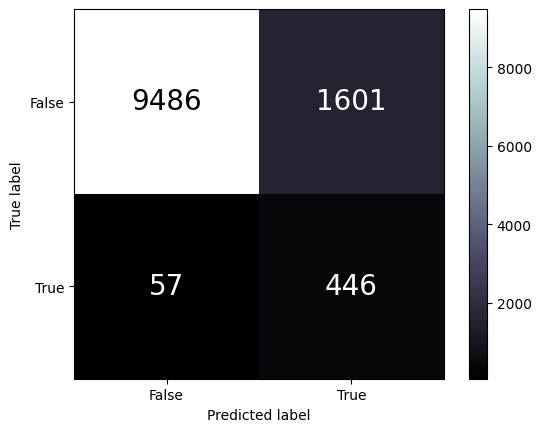

In [132]:
log_reg = train_and_score(LogisticRegression(max_iter=250, class_weight='balanced'), X_train, X_test, y_train, y_test)

In [156]:
import xgboost as xgb
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV

classes_weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_train)

cv_params = {
    "xgbclassifier__reg_alpha": [0.05, 0.1, 1, 2, 3],
    "xgbclassifier__reg_lambda": [0.05, 0.1, 1, 2, 3],
}  # {'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}#{'max_depth':[3,4,5,6,7,8,9,10],'min_child_weight':[1,2,3,4,5,6,7,8,9,10],'gamma':[0,0.1,0.2,0.3,0.4,0.5]} #{'n_estimators':[50,100,200,400,500],'learning_rate':[0.01,0.05,0.1,0.2,0.3]}#
other_params = {
    "learning_rate": 0.2,
    "n_estimators": 400,
    "max_depth": 8,
    "min_child_weight": 1,
    "seed": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.8,
    "gamma": 0.2,
    # "reg_alpha": 1,
    # "reg_lambda": 0.1,
}
xgb_model = feature_transform_pipe(xgb.XGBClassifier(), X_train)
optimized = GridSearchCV(estimator=xgb_model, param_grid=cv_params, scoring="roc_auc", cv=3, verbose=2, n_jobs=8)
optimized.fit(X_train, y_train,xgbclassifier__sample_weight=classes_weights)

['operator']
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.05; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=1; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.05; total time=   0.5s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.05; total time=   0.5s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.1; total time=   0.5s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.1; total time=   0.5s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.1; total time=   0.5s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=1; total time=   0.5s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=1; total time=   0.5s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=2; total time=   0.5s
[CV] END xgbclassifier__reg_alp

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['cardinality_S',
                                                                          'cardinality_T',
                                                                          'comp_lmm_fac',
                                                                          'comp_lmm_mat',
                                                                          'comp_ratio',
                                                                          'comp_scalar_dense',
                                                                          'fr',
                                                                          'mem_write_rowsum',
                                                                          'nnz_S_sum',
                                                                          'nnz_T',
                                                                          'r_T',
                                                                          'c_T',
                                                                          'selectivity',
                                                                          'sparsity_T',
                                                                          'tr',
                                                                          'gpu_memory_bandwidth',
                                                                          'gpu_cores',
                                                                          'gpu_clock...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=8,
             param_grid={'xgbclassifier__reg_alpha': [0.05, 0.1, 1, 2, 3],
                         'xgbclassifier__reg_lambda': [0.05, 0.1, 1, 2, 3]},
             scoring='roc_auc', verbose=2)

Model <class 'sklearn.model_selection._search.GridSearchCV'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'gpu_memory_bandwidth', 'gpu_cores',
       'gpu_clock_speed'],
      dtype='object')
Test accuracy Score: 0.986281276962899
Test precision Score: 0.773015873015873
Test recall Score: 0.9681908548707754
Test f1 Score: 0.8596646072374229


({'accuracy': 0.986281276962899,
  'precision': 0.773015873015873,
  'recall': 0.9681908548707754,
  'f1': 0.8596646072374229},
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f2b1dbc4cd0>)

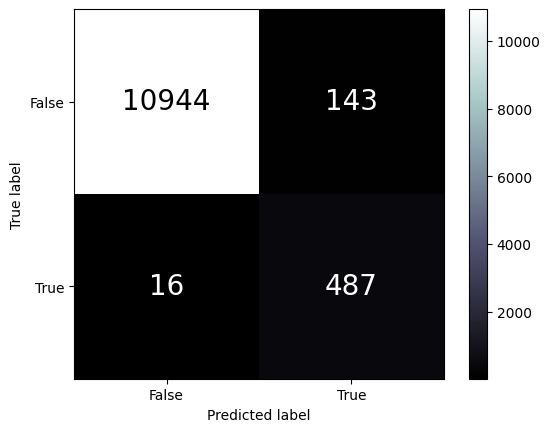

In [163]:
xgb_optimized = optimized
eval_model(optimized, X_test, y_test)

Model <class 'src.estimators.MorpheusFI'>, test cols: Index(['morpheusfi_p', 'morpheusfi_q', 'morpheusfi_eis', 'morpheusfi_ns',
       'morpheusfi_nis'],
      dtype='object')
Test accuracy Score: 0.04339948231233822
Test precision Score: 0.04339948231233822
Test recall Score: 1.0
Test f1 Score: 0.08318862151657984
Model <class 'src.estimators.Morpheus'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'gpu_memory_bandwidth', 'gpu_cores',
       'gpu_clock_speed'],
      dtype='object')
Test accuracy Score: 0.26160483175150995
Test precision Score: 0.04321197686287853
Test recall Score: 0.757455268389662
Test f1 Score: 0.08175965665236051
Model <class 'src.estimators.Amalur'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_sc

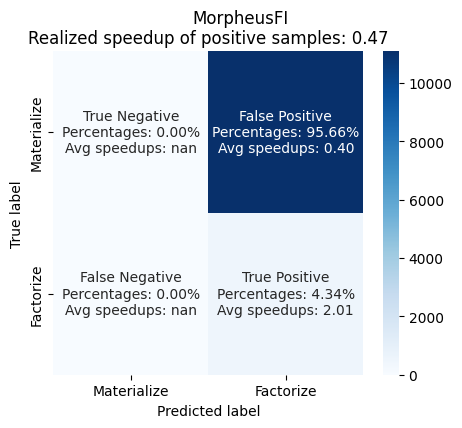

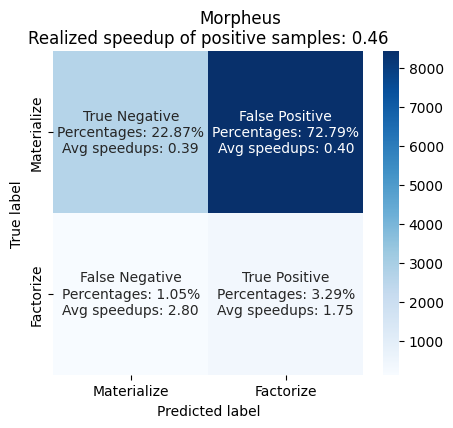

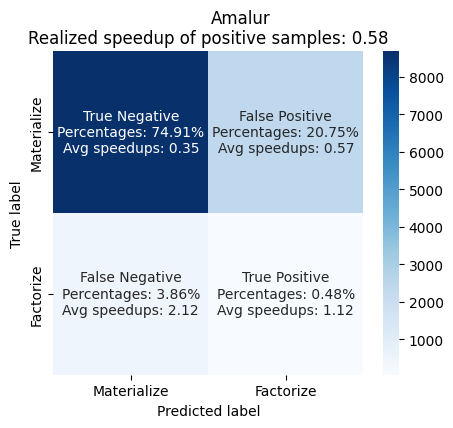

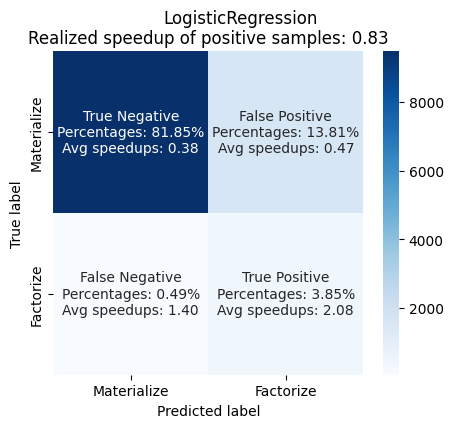

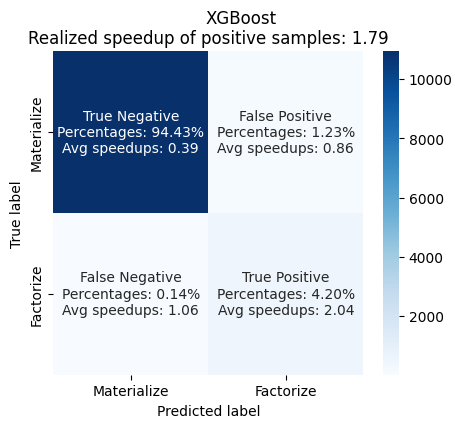

In [175]:
from src.estimators import MorpheusFI, Morpheus, Amalur
import src.estimators
from src.estimators import eval_model
importlib.reload(src.estimators)
result_compare = {}
log_reg.__class__.__name__ = "LogisticRegression"
xgb_optimized.__class__.__name__ = "XGBoost"

for model in [MorpheusFI(), Morpheus(), Amalur(), log_reg, xgb_optimized]:
    if isinstance(model, MorpheusFI):
        result_compare[model.__class__.__name__], _ = eval_model(model, test[[x for x in test.columns if 'morpheusfi' in x]], y_test, speedup=test.speedup)
    else: 
        result_compare[model.__class__.__name__], _ = eval_model(model, X_test, y_test, speedup=test.speedup)

Model <class 'src.estimators.MorpheusFI'>, test cols: Index(['morpheusfi_p', 'morpheusfi_q', 'morpheusfi_eis', 'morpheusfi_ns',
       'morpheusfi_nis'],
      dtype='object')
Test accuracy Score: 0.04803312629399586
Test precision Score: 0.04803312629399586
Test recall Score: 1.0
Test f1 Score: 0.0916633741604109
Model <class 'src.estimators.Morpheus'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'gpu_memory_bandwidth', 'gpu_cores',
       'gpu_clock_speed'],
      dtype='object')
Test accuracy Score: 0.2639751552795031
Test precision Score: 0.04603825136612022
Test recall Score: 0.7262931034482759
Test f1 Score: 0.08658787255909557
Model <class 'src.estimators.Amalur'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_sca

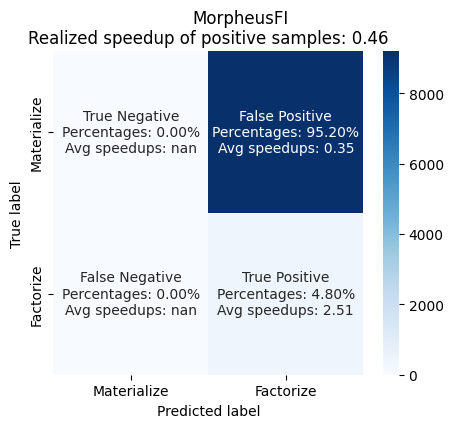

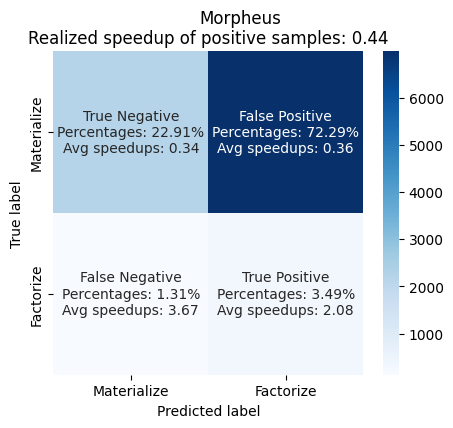

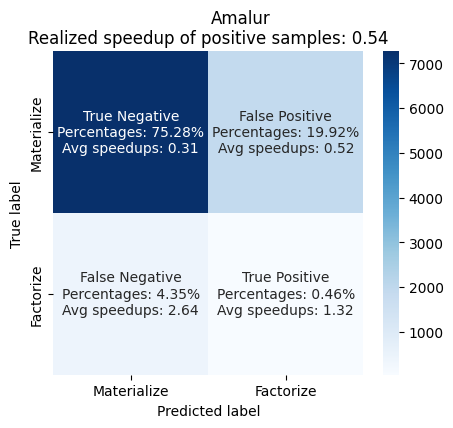

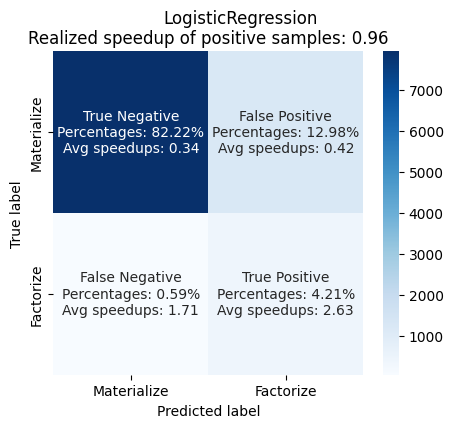

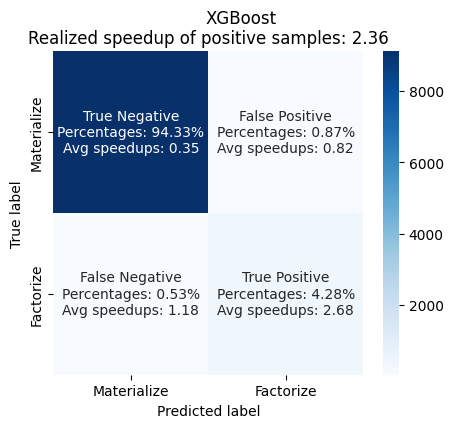

In [177]:
X_validate, y_validate = validate[model_features], validate["label"]

hamlet_result = {}
for model in [MorpheusFI(), Morpheus(), Amalur(), log_reg, xgb_optimized]:
    if isinstance(model, MorpheusFI):
        hamlet_result[model.__class__.__name__], _ = eval_model(model, validate[[x for x in test.columns if 'morpheusfi' in x]], y_validate, speedup=validate.speedup)
    else: 
        hamlet_result[model.__class__.__name__], _ = eval_model(model, X_validate, y_validate, speedup=validate.speedup)